In [2]:
import numpy as np 
from scipy.stats import norm
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
import plotly.graph_objects as go

### Simulating option basket price
$$ \mathrm{d}S_t^k = S_t^k(r \mathrm{d}t + \sigma^k \mathrm{d}W_t^k) \textrm{ and } \mathrm{d}<W^k,W^j>_t = \rho \mathrm{d}t \textrm{ for } k\neq j$$
The option basket call has payoff : $$ I_T = (\sum \alpha_k S_T^k - K)_+ $$

In [3]:
def simulate_basket_option(N_trajectories, confidence, alpha, rho, S0, sigmas, r, t, strike):
    mean = np.zeros(alpha.shape[0])
    variance_matrix = rho*np.ones((alpha.shape[0],alpha.shape[0])) + (1-rho)*np.diag(np.ones(alpha.shape[0]))  
    prices = np.random.multivariate_normal(mean=mean, cov=variance_matrix, size=N_trajectories)
    prices = (r-0.5*(sigmas**2.0))*t + np.sqrt(t)*sigmas*prices
    prices = S0*np.exp(prices)
    option_basket = np.maximum((alpha*prices).sum(axis=1) - strike, 0)
    price = np.mean(option_basket)
    std = np.std(option_basket)
    confidence_interval_size = (norm.ppf((1.+confidence)/2.)*std)**2.0/N_trajectories
    return price, std, confidence_interval_size

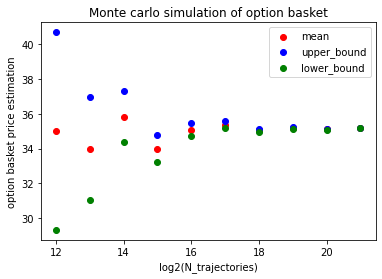

In [243]:
X = [int(2**k) for k in range(12,22)]
Y = [simulate_basket_option(N_trajectories = x, 
                       confidence = 0.95, 
                       alpha = 1./10*np.ones(10), 
                       rho = 0.5, 
                       S0 = 100*np.ones(10), 
                       sigmas = np.ones(10), 
                       r = 0.1, 
                       t = 1.0, 
                       strike =103) for x in X]

estimation = np.array([y[0] for y in Y])
confidence = np.array([y[2] for y in Y])

X_1 = range(12,22)
plt.scatter(X_1, estimation, c = 'red', label = 'mean')
plt.scatter(X_1, estimation+confidence, c = 'blue', label = 'upper_bound')
plt.scatter(X_1, estimation-confidence, c = 'green', label = 'lower_bound')
plt.title('Monte carlo simulation of option basket')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('option basket price estimation')
plt.legend()






In [244]:
plt.figure()

x = np.linspace(90, 110, 40)
z = np.zeros((40,40))
for k in range(40):
    for j in range(40):
        S_1 = x[k]
        S_2 = x[j]
        z[k,j] = simulate_basket_option(N_trajectories = 100000, 
                       confidence = 0.95, 
                       alpha = np.array([0.8, 0.2]), 
                       rho = 0.5, 
                       S0 = np.array([S_1, S_2]), 
                       sigmas = np.array([0.9, 0.3]), 
                       r = 0.2, 
                       t = 1.0, 
                       strike = 100)[0]

        

<Figure size 432x288 with 0 Axes>

In [245]:
fig = go.Figure(data=[go.Surface(z=z, x=x, y=x)])
fig.update_layout(title='Option Basket price surface')
fig.show()

In [246]:
def compute_call_BS(S0, T, K, sigma, r, q=0, t=0):
    d_plus = (1./(sigma*np.sqrt(T-t)))*np.log(S0/(K*np.exp(-(r-q)*(T-t)))) + 0.5*sigma*np.sqrt(T-t)
    d_moins = d_plus - sigma*np.sqrt(T-t)
    call = S0*np.exp(-q*(T-t))*norm.cdf(d_plus) - K*np.exp(-r*(T-t))*norm.cdf(d_moins)
    return call

In [247]:
np.exp(np.log(100) -0.5 +0.5*0.55)

79.85162187593777

In [248]:
def simulate_basket_option_control_variable(N_trajectories, confidence, alpha, rho, S0, sigmas, r, t, strike):
    mean = np.zeros(alpha.shape[0])
    variance_matrix = rho*np.ones((alpha.shape[0],alpha.shape[0])) + (1-rho)*np.diag(np.ones(alpha.shape[0]))  
    
    prices = np.random.multivariate_normal(mean=mean, cov=variance_matrix, size=N_trajectories)
    prices = (r-0.5*(sigmas**2.0))*t + np.sqrt(t)*sigmas*prices
    prices = S0*np.exp(prices)
    
    control_variable = np.exp((alpha*np.log(prices)).sum(axis = 1))
    control_variable = np.maximum(control_variable - strike, 0)

    option_basket = np.maximum((alpha*prices).sum(axis=1) - strike, 0)
    
    control_variable_variance = np.dot(alpha*sigmas, np.matmul(variance_matrix, alpha*sigmas))*t
    
    initial_price_control_BS = np.exp( (alpha*np.log(S0)).sum(axis = 0) 
                                      - 0.5*(alpha*(sigmas**2.0)).sum(axis =0) 
                                      + 0.5*control_variable_variance )
                                      
    price_BS = compute_call_BS(S0 = initial_price_control_BS,
                                                T = t, 
                                                K = strike, 
                                                sigma = np.sqrt(control_variable_variance/t),
                                                r = r)
    price_basket = option_basket - control_variable
    std = np.std(price_basket)
    price_basket = np.mean(price_basket) + np.exp(r*t)*price_BS
    confidence_interval_size = (norm.ppf((1.+confidence)/2.)*std)**2.0/N_trajectories
    return price_basket, std, confidence_interval_size


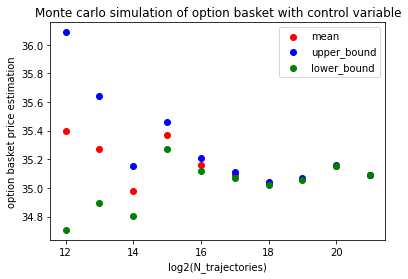

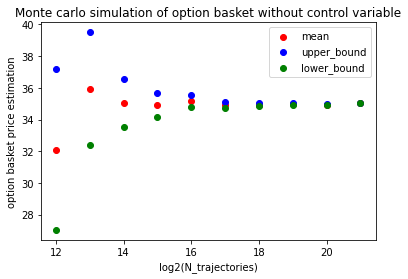

In [249]:
X = [int(2**k) for k in range(12,22)]
Y = [simulate_basket_option_control_variable(N_trajectories = x, 
                       confidence = 0.95, 
                       alpha = 1./10*np.ones(10), 
                       rho = 0.5, 
                       S0 = 100*np.ones(10), 
                       sigmas = np.ones(10), 
                       r = 0.1, 
                       t = 1.0, 
                       strike =103) for x in X]

estimation = np.array([y[0] for y in Y])
confidence = np.array([y[2] for y in Y])

X_1 = range(12,22)
plt.scatter(X_1, estimation, c = 'red', label = 'mean')
plt.scatter(X_1, estimation+confidence, c = 'blue', label = 'upper_bound')
plt.scatter(X_1, estimation-confidence, c = 'green', label = 'lower_bound')
plt.title('Monte carlo simulation of option basket with control variable')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('option basket price estimation')
plt.legend()

plt.figure()
X = [int(2**k) for k in range(12,22)]
Y = [simulate_basket_option(N_trajectories = x, 
                       confidence = 0.95, 
                       alpha = 1./10*np.ones(10), 
                       rho = 0.5, 
                       S0 = 100*np.ones(10), 
                       sigmas = np.ones(10), 
                       r = 0.1, 
                       t = 1.0, 
                       strike =103) for x in X]

estimation = np.array([y[0] for y in Y])
confidence = np.array([y[2] for y in Y])

X_1 = range(12,22)
plt.scatter(X_1, estimation, c = 'red', label = 'mean')
plt.scatter(X_1, estimation+confidence, c = 'blue', label = 'upper_bound')
plt.scatter(X_1, estimation-confidence, c = 'green', label = 'lower_bound')
plt.title('Monte carlo simulation of option basket without control variable')
plt.xlabel('log2(N_trajectories)')
plt.ylabel('option basket price estimation')
plt.legend()


